# Exploratory Data Analysis (EDA)

### Data Horizon Selection (MSFT)

- ~1 year of data is too short to reveal stable lag and volatility patterns.
- Very long histories include periods with different market conditions and business focus.
- Microsoft experienced major leadership and strategic changes around 2013, followed by a different close price behavior in subsequent years.
- Using data from **2014 onward** provides enough history while remaining relevant for forecasting.

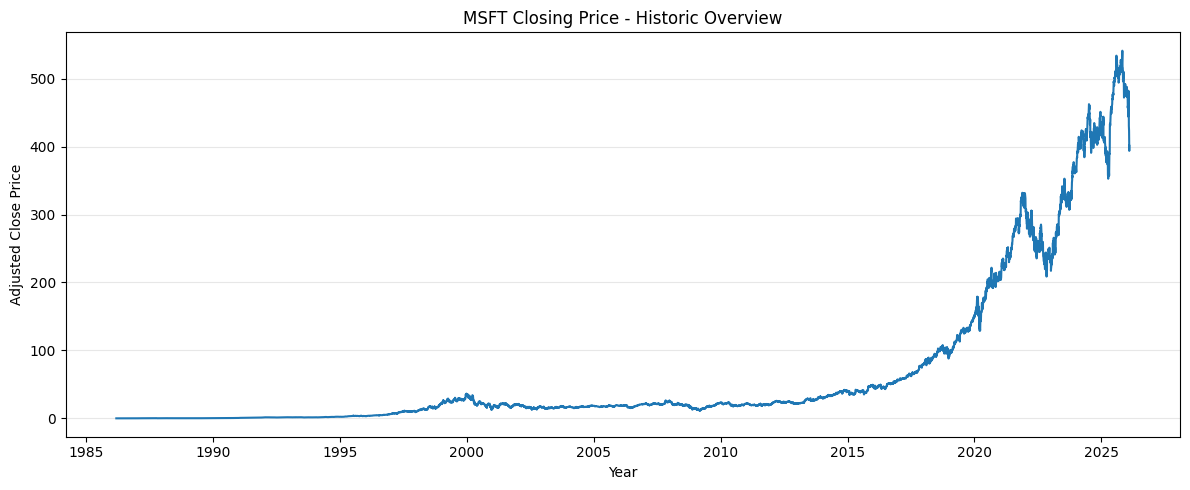

For interactive plots, please run this notebook locally or use [![Binder]](https://mybinder.org/v2/gh/shashankgarewal/Time-Series-Analysis-Forecasting/HEAD?filepath=notebooks/02_eda_analysis.ipynb)

## Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels as sm

In [16]:
# decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
# stationary
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import ks_2samp
# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [17]:
# for interactive plot
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, HTML 

In [18]:
# fix runtime autoclose in collab
import ipykernel
ipykernel.version_info

(6, 29, 5)

## Data Load and Feature Computation

In [19]:
df = yf.download('MSFT', start="2014-01-01", auto_adjust=True, progress=False)
df.columns = [col[0] for col in df.columns]
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2014-01-02,30.831125,31.030251,30.781343,30.988764,30632200
2014-01-03,30.623713,30.880916,30.366509,30.864322,31134800
2014-01-06,29.976562,30.607123,29.959968,30.573934,43603700
2014-01-07,30.208868,30.275244,30.042930,30.142495,35802800
2014-01-08,29.669573,29.984854,29.520232,29.868699,59971700


In [20]:
df['Return'] = df['Close'].pct_change()
df['LogReturn'] = np.log(df['Close']).diff()
df.describe()

,Close,High,Low,Open,Volume,Return,LogReturn
count,3043.000000,3043.000000,3043.000000,3043.000000,3.043000e+03,3042.000000,3042.000000
mean,194.097402,195.861288,192.165717,194.067923,2.877453e+07,0.000983,0.000843
std,146.406685,147.644194,145.082715,146.438749,1.364206e+07,0.016695,0.016691
min,29.022411,29.769135,28.732028,28.814995,5.855900e+06,-0.147390,-0.159453
25%,56.650171,57.037015,56.258830,56.636679,2.034280e+07,-0.006774,-0.006797
50%,149.457916,150.189816,146.647363,148.850189,2.562750e+07,0.000868,0.000867
75%,299.025543,301.634054,296.342485,299.457240,3.315345e+07,0.009362,0.009318
max,541.057373,553.502444,539.759814,553.283183,2.025224e+08,0.142169,0.132929


## General Data Exploration

### Diagnose date gaps

In [21]:
df.index.diff().value_counts().head()

Date
1 days    2380
3 days     548
4 days      83
2 days      31
Name: count, dtype: int64

In [22]:
# df for gap vs jump relation
analysis_df = df.copy()
analysis_df['GapDays'] = analysis_df.index.to_series().diff().dt.days
analysis_df['AbsJumpInClose'] = analysis_df['Close'].diff().abs()
analysis_df = analysis_df.dropna()

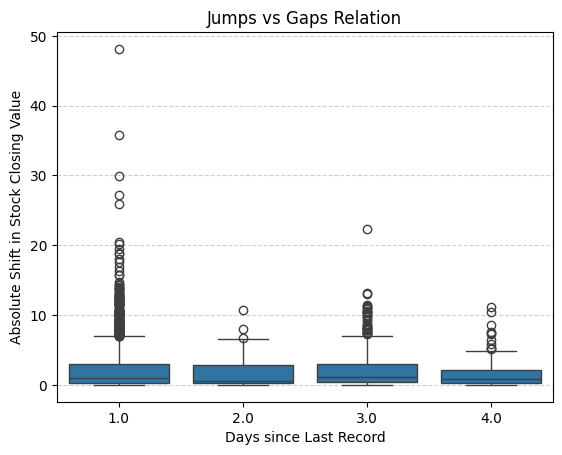

In [23]:
sns.boxplot(data=analysis_df, x = 'GapDays', y = 'AbsJumpInClose')
plt.title('Jumps vs Gaps Relation')
plt.xlabel('Days since Last Record')
plt.ylabel('Absolute Shift in Stock Closing Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [24]:
analysis_df.groupby('GapDays')['AbsJumpInClose'].describe()

,count,mean,std,min,25%,50%,75%,max
GapDays,,,,,,,,
1.0,2380.0,2.288318,3.248253,0.000000,0.325703,0.999104,3.005322,48.130005
2.0,31.0,2.019600,2.817933,0.037468,0.242943,0.632904,2.801239,10.679993
3.0,548.0,2.170306,2.683015,0.000000,0.360283,1.089630,3.065201,22.288071
4.0,83.0,1.905150,2.520612,0.008640,0.239794,0.837803,2.180840,11.091965


* The longer gaps (more than 1 day) doesn't affect the jumps, suggesting no abnormality in stock data. 


* The more outliers in shorter gaps suggest more jumps in close price than large gaps. The consecutive days have higher volatility and are more concerning.

### Distribution

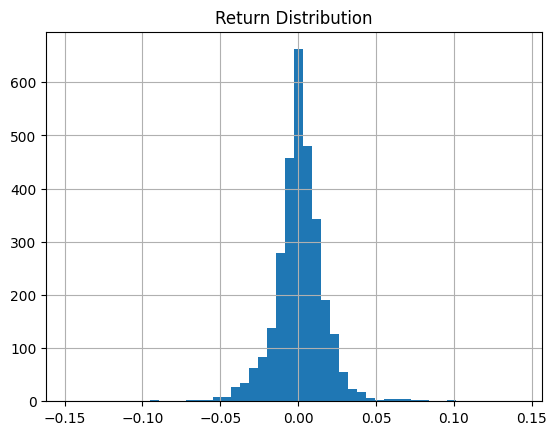

In [25]:
df["Return"].hist(bins=50)
plt.title("Return Distribution")
plt.show()

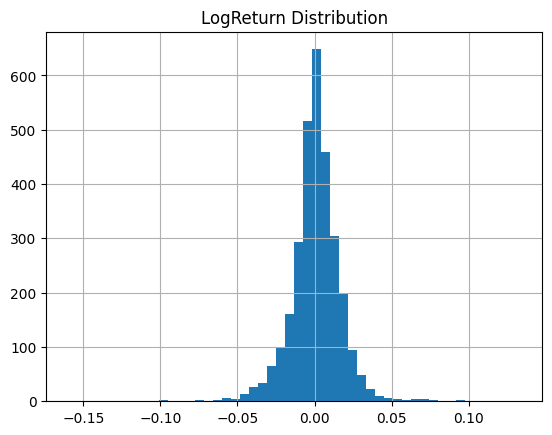

In [26]:
df["LogReturn"].hist(bins=50)
plt.title("LogReturn Distribution")
plt.show()

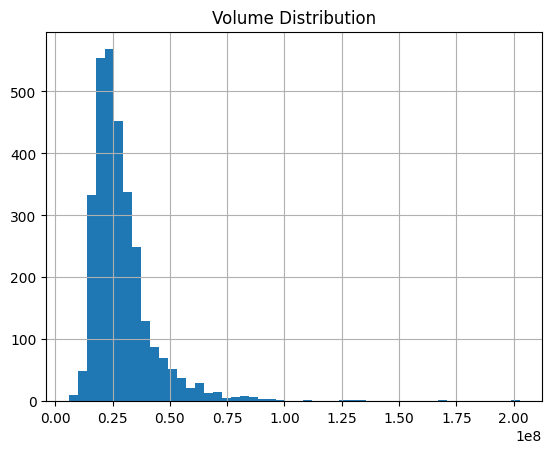

In [27]:
df['Volume'].hist(bins=50)
plt.title('Volume Distribution')
plt.show()

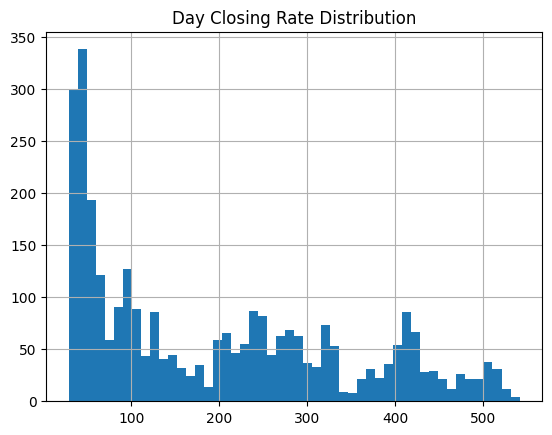

In [28]:
df['Close'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

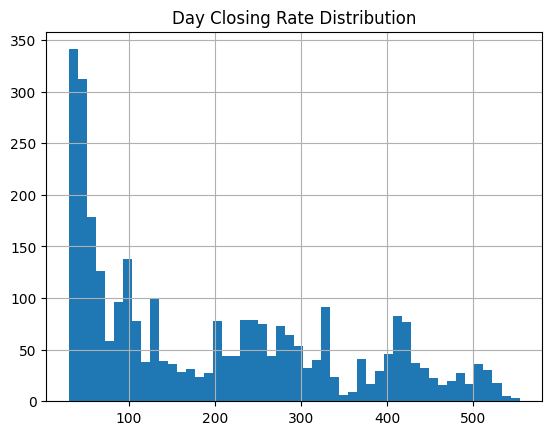

In [29]:
df['High'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

* Stock open and close price show multimodal distribution.
  * Tree-based (XGBoost, Random Forest) and Hidden Markov Model might work better than ARIMA or LSTM that work on sequencial data, or could be effect of trend.
  * Feature Engineering may benefit in sequencial based models
* Return and log of return show normal distribution, better for modeling even ML and DL models
* Volume shows positively skewed distribution

## Exploration Relevant to Forecast

### Decomposition


In [ ]:
(df.index.year == 2014).sum()

np.int64(252)

AttributeError: 'Figure' object has no attribute 'figsize'

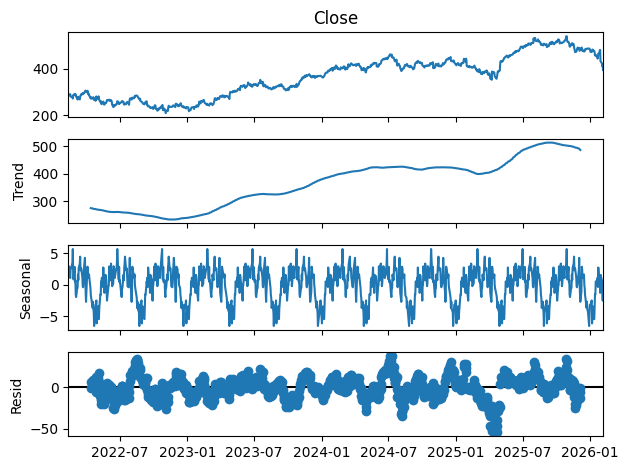

In [ ]:
decomp.plot().figur


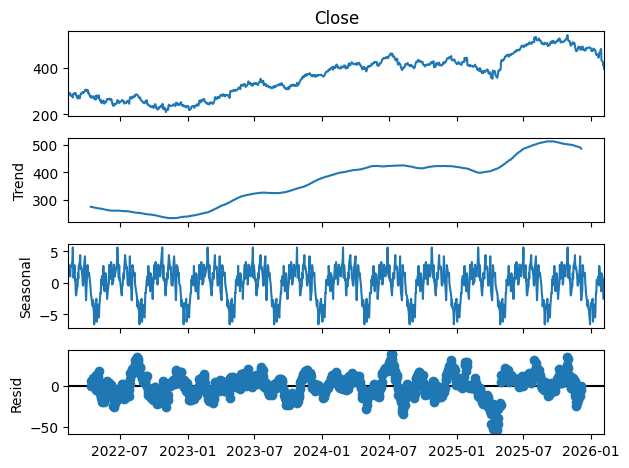

In [71]:
decomp = seasonal_decompose(df['Close'][-1000:], model='additive', period=84)

decomp.plot().figure
fig.suptitle('Seasonal Additive Decomposition', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


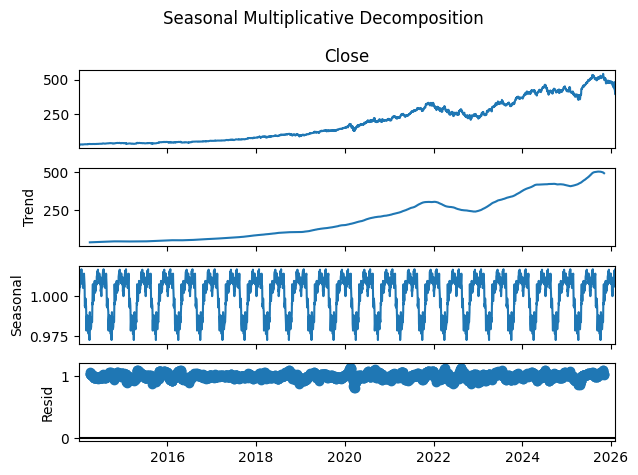

In [52]:
decomp = seasonal_decompose(df['Close'], model='multiplicative', period=126)
decomp.plot()
plt.suptitle('Seasonal Multiplicative Decomposition')
plt.tight_layout()
plt.show()

In [63]:
decomp.resid.describe()

count    2771.000000
mean        0.999837
std         0.020131
min         0.888954
25%         0.987988
50%         1.000455
75%         1.011572
max         1.080116
Name: resid, dtype: float64

* additive decomposition has uncaptured information (functionation of ±20 in residual)
* multiplicative decomposition has small seasonal component (~1 unit in values of 350-500 units) can be forced and weak/unhelpful.

Requires further seasonality validation, will be done by ACF/PACF.

In [ ]:
# additive decomposition is stl - offers freedom to seasonal component
def plot_stl(period, seasonal):
    stl = STL(df['Close'], period=period, seasonal=seasonal, robust=True)
    result = stl.fit()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

    ax1.plot(result.trend, color='red')
    ax1.set_title('Trend Component')

    ax2.plot(result.seasonal, color='blue')
    ax2.set_title('Seasonal Component')

    ax3.plot(result.resid, color='green')
    ax3.set_title('Residual Component')

    plt.suptitle(f'STL Decomposition on Close: Period: {period}, Seasona: {seasonal}')
    plt.tight_layout()
    plt.show()

# set STATIC = True, for interactive widget plot
STATIC = False

if not STATIC:
    interact(plot_stl, 
            period=widgets.IntSlider(min=3, max=71, step=1, value=25),
            seasonal=widgets.IntSlider(min=7, max=151, step=2, value=21)
    );
else:
    # GitHub fallback: render a static example 
    plot_stl(period=25, seasonal=21)

interactive(children=(IntSlider(value=25, description='period', max=71, min=3), IntSlider(value=21, descriptio…

For interactive plots, please run this notebook locally or use [![Binder]](https://mybinder.org/v2/gh/shashankgarewal/Time-Series-Analysis-Forecasting/HEAD?filepath=notebooks/02_eda_analysis.ipynb)

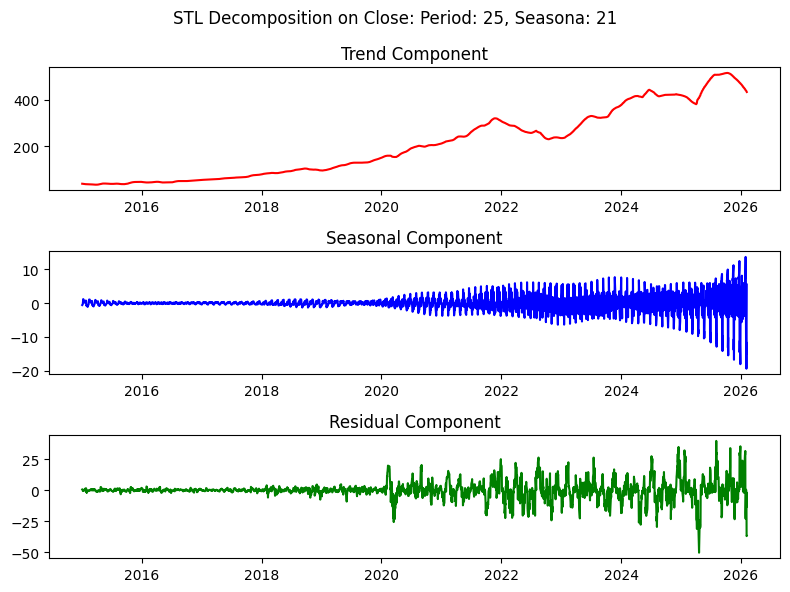

In [ ]:
# multiplicative stl decomposition -
# as data has curve in trend, multiplicative decomposition might better
def plot_mstl(period, seasonal):
    stl = STL(np.log(df['Close']), period=period, seasonal=seasonal, robust=True)
    result = stl.fit()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

    ax1.plot(result.trend, color='red')
    ax1.set_title('Trend Component')

    ax2.plot(result.seasonal, color='blue')
    ax2.set_title('Seasonal Component')

    ax3.plot(result.resid, color='green')
    ax3.set_title('Residual Component')

    plt.suptitle(f'STL Decomposition on Log(Close): Period: {period}, Seasona: {seasonal}')
    plt.tight_layout()
    plt.show()

# set STATIC = False, for interactive widget plot
STATIC = True

if not STATIC:
    interact(plot_mstl, 
            period=widgets.IntSlider(min=3, max=71, step=1, value=25),
            seasonal=widgets.IntSlider(min=3, max=151, step=2, value=21)
    );
else:
    # GitHub fallback: render a static example 
    plot_stl(period=25, seasonal=21)

For interactive plots, please run this notebook locally or use [![Binder]](https://mybinder.org/v2/gh/shashankgarewal/Time-Series-Analysis-Forecasting/HEAD?filepath=notebooks/02_eda_analysis.ipynb)

* The stl decomposition of series and log-series shows much weaker seasonality, than classic decomposition, indicates weak seasonal comp in series.
* Log decomp didn't improved the residual or seasonality; suggesting series behaves almost additively and **neglible multiplicative effect**.
* The residual component **dominates the comp** and exhibits spikes and **volatility**, is not a white noise; and imply irregular fluctuation drives the series more than any stable periodic pattern.
* ACF, PACF needed here also for checking further dependence and pattern.

[domain-info] some noises in stock data is normal, comes from daily news, events.

### Stationarity Check
Model performs better if data has stationarity, some even assumes stationary data

raw Close price is already non-stationary (has trend). 

Check will be performed on Log Return, as log may not cause vanishing exploding gradient problem in model.

Log return provide some meaning benefits over other transformation (return) like; during forecast there will be no intermediate price dependence, addition instead of multiply during reconstruction of Close price.

In [ ]:
# weak stationary test

## augmented dickey fuller - diff based
## null hypothesis; non-stationary (series has root unit)
def get_adfuller(series, name=""):
    adf_result = adfuller(series.dropna())
    print(f"adfuller test on {name}: {name} stationary if p < 0.05 | stat < critical values\n")
    adf_result = adfuller(df['Return'].dropna())

    print("p-value:", adf_result[1])
    print("adf stat:", adf_result[0])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'{key}: {round(value, 3)}')

## kpss test
## null hypothesis: stationary series     
def get_kpss(series, literal='ct', name=""):
    kpss_result = kpss(series.dropna(), literal)
    print(f"kpss test on {name}: {name} stationary if p > 0.05 | stat > critical values\n")
    print("p-value:", kpss_result[1])
    print("adf stat:", kpss_result[0])
    print('Critical Values for Return:')
    for key, value in kpss_result[3].items():
      print(f'{key}: {round(value, 3)}')

In [ ]:
get_adfuller(df['LogReturn'], "log return")

adfuller test on log return: log return stationary if p < 0.05 | stat < critical values

p-value: 2.539897510137116e-30
adf stat: -18.10948481303955
Critical Values:
1%: -3.433
5%: -2.863
10%: -2.567


In [ ]:
get_kpss(df['LogReturn'], "ct", "log return")

kpss test on log return: log return stationary if p > 0.05 | stat > critical values

p-value: 0.1
adf stat: 0.06214861602018706
Critical Values for Return:
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216


C:\Users\Monika\AppData\Local\Temp\ipykernel_9628\1777155583.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), literal)


In [69]:
# join distribution test for strict stationarity
## ks test
## null hyphothesis: stationary
def get_ks(series, name=""):
    print(f"ks test on {name}: stationary if p > 0.05\n")
    split = len(series.dropna()) // 2
    stat, pvalue = ks_2samp(series.dropna()[0:split],
                            series.dropna()[split:-1])
    print(f"KS Statistic: {stat:.4f}")
    print(f"P-value: {pvalue:.4f}")

In [ ]:
get_ks(df['LogReturn'], 'log-return')

ks test on log-return: stationary if p > 0.05

KS Statistic: 0.0561
P-value: 0.0238


Log-Return Stationarity Check:
* ADF: both p and stat << 0.05; meaning the constant mean. reject non-stationarity.
* KPSS: p is slightly < 0.05, and the stat > the 5% critical value; meaning variance isn't constant. The voltility (as appeared in residual comp) or autocorrelation might be triggering the rejection.
* KS: p > 0.05; series has no difference in join distribution. series is stationary.

Conclusion: The LogReturn series is sufficiently stationary and distributionally stable.

### Autocorrelation
correlation of the feature with its own past values

#### Close price statistics reverify

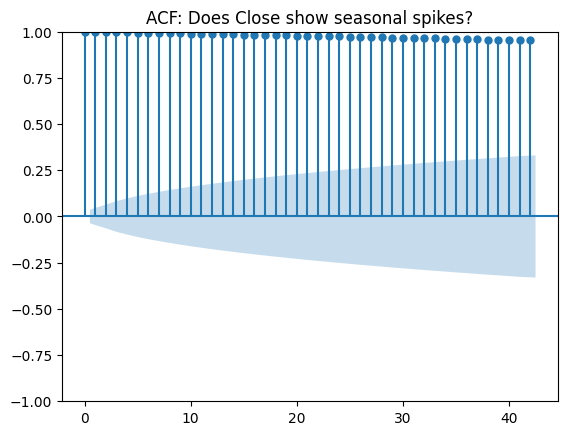

In [ ]:
plot_acf(df["Close"].dropna(), lags=42)
plt.title("ACF: Does Close show seasonal spikes?")
plt.show()

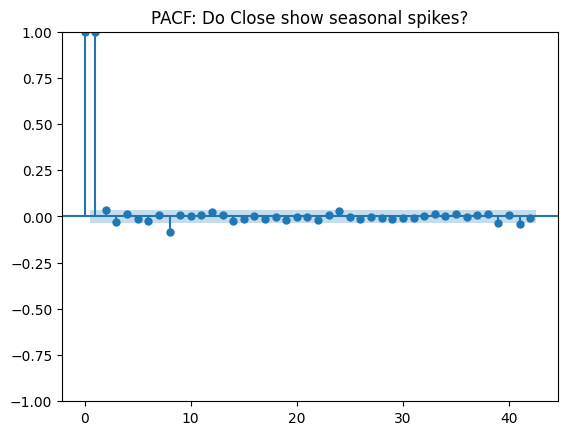

In [ ]:
plot_pacf(df["Close"].dropna(), lags=42)
plt.title("PACF: Do Close show seasonal spikes?")
plt.show()

ACF of close price shows gradual decay, series with trends; and no significant spikes at lag intervals in ACF and PACF confirm no seasonality in close price. 

#### Check Log-Return lag structure and model order

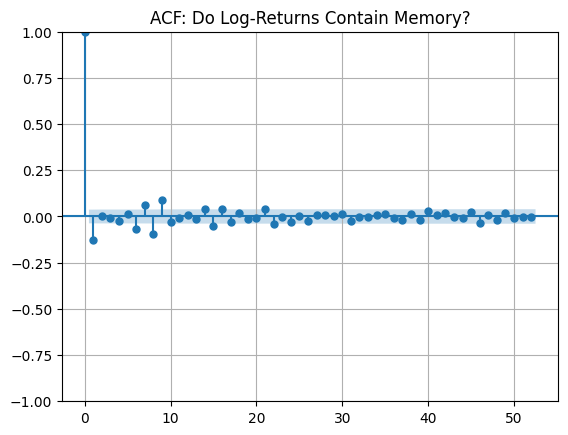

In [ ]:
plot_acf(df["LogReturn"].dropna(), lags=52)
plt.title("ACF: Do Log-Returns Contain Memory?")
plt.grid()
plt.show()

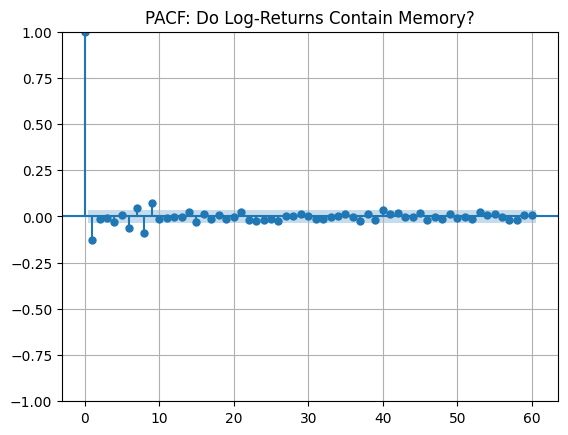

In [ ]:
plot_pacf(df["LogReturn"].dropna(), lags=60)
plt.grid()
plt.title("PACF: Do Log-Returns Contain Memory?")
plt.show()

1 to 60 lags p-values: 
 [4.30702024e-11 3.63430328e-10 1.85753602e-09 2.93287448e-09
 8.38787378e-09 1.07539728e-10 2.20417478e-12 3.98294065e-17
 3.55902106e-21 4.45723440e-21 1.47368263e-20 4.69785432e-20
 1.18138827e-19 5.66908730e-20 5.56719174e-21 2.20640881e-21
 1.84044723e-21 3.78816888e-21 8.41042854e-21 2.12894927e-20
 9.73167062e-21 4.27091513e-21 1.11616104e-20 9.87359389e-21
 2.51795309e-20 2.93386536e-20 6.84616138e-20 1.47717736e-19
 3.43764254e-19 6.63864570e-19 7.76276989e-19 1.72652760e-18
 3.79251157e-18 7.41548976e-18 1.39172574e-17 2.87751448e-17
 4.12209589e-17 6.68293218e-17 9.50047707e-17 7.12689423e-17
 1.34492472e-16 1.98476777e-16 3.93943725e-16 7.34126543e-16
 7.87525986e-16 4.67058562e-16 8.08957689e-16 1.04432280e-15
 1.36509198e-15 2.29546215e-15 4.22303756e-15 7.75684309e-15
 1.11907574e-14 1.39946746e-14 2.53215843e-14 4.43178541e-14
 4.36364987e-14 6.72048930e-14 1.10062820e-13 1.90249310e-13]


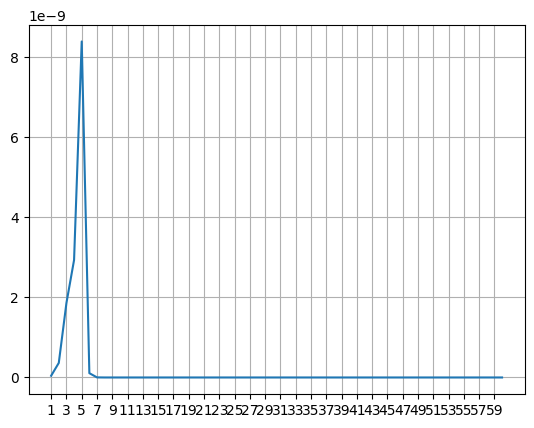

In [ ]:
jung_result = acorr_ljungbox(df['LogReturn'].dropna(), lags=60, return_df=True)
print('1 to 60 lags p-values: \n', jung_result['lb_pvalue'].values)
jung_result['lb_pvalue'].plot()
plt.xticks(np.arange(1, 60, 2))
plt.grid()
plt.show()

ACF and PACF are mostly inside the confidence band, indicating the absence of trend, seasonality, or linear memory in the mean. 

Some spikes (Lag 15, 28, 38, 42, 48) near borderline of confidence band indicates volatility, or randomness behaviour, or non-constant variance which seems common in stock data.

ljung box test confirmed the log return has **no linear autocorrelation**. 

### Volatility Check
For white noise, volatility, and variance

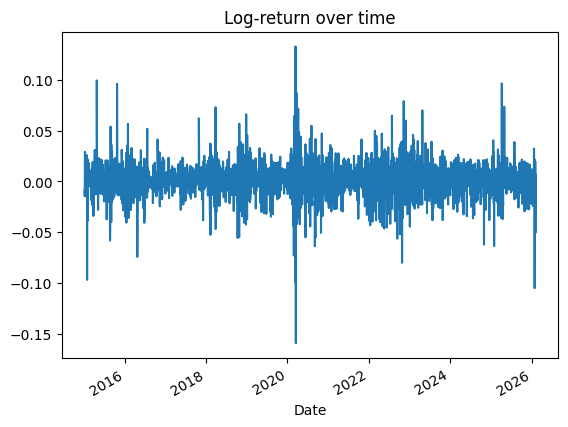

In [ ]:
df['LogReturn'].plot()
plt.title('Log-return over time');

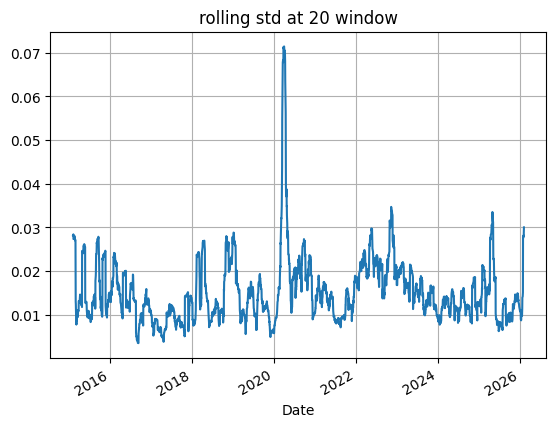

In [ ]:
rolling_std = df["LogReturn"].rolling(20).std()
rolling_std.plot()
plt.grid()
plt.title('rolling std at 20 window');

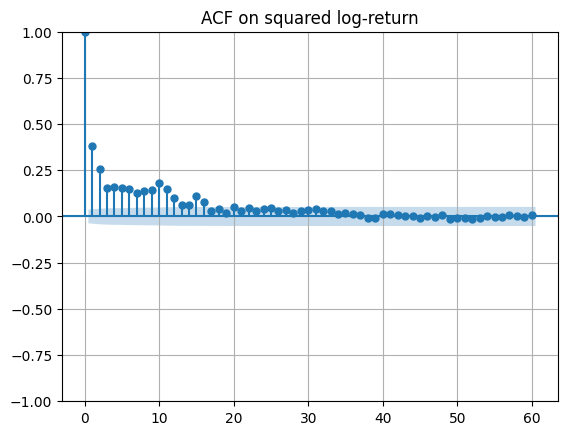

In [ ]:
plot_acf((df['LogReturn'] ** 2).dropna(), lags=60)
plt.grid()
plt.title('ACF on squared log-return')
plt.show()

Log Return plot also suggest the log-return is mostly noisey.

The standard deviation with 20 rolling window show that the magnitude of the swings (jump/change in log return) is not random.

ACF on squared log-return with some borderline peaks (5, 15, 48 lags) is suggesting that even though the log-return is random and noisy, but the risk are predictable.

Since the data has volatility cluters, we can perform **GARCH modeling**.